In [ ]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import pandas_profiling
import seaborn as sns
import datetime as dt
from sklearn.model_selection import GridSearchCV
import xgboost as xgb# for XGBoost algorithm
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


In [ ]:
df = pd.read_csv("/content/solar_weather.csv")

In [ ]:
df.head()

,Time,Energy delta[Wh],GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,isSun,sunlightTime,dayLength,SunlightTime/daylength,weather_type,hour,month
0,2017-01-01 00:00:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.0,4,0,1
1,2017-01-01 00:15:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.0,4,0,1
2,2017-01-01 00:30:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.0,4,0,1
3,2017-01-01 00:45:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.0,4,0,1
4,2017-01-01 01:00:00,0,0.0,1.7,1020,100,5.2,0.0,0.0,100,0,0,450,0.0,4,1,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196776 entries, 0 to 196775
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Time                    196776 non-null  object 
 1   Energy delta[Wh]        196776 non-null  int64  
 2   GHI                     196776 non-null  float64
 3   temp                    196776 non-null  float64
 4   pressure                196776 non-null  int64  
 5   humidity                196776 non-null  int64  
 6   wind_speed              196776 non-null  float64
 7   rain_1h                 196776 non-null  float64
 8   snow_1h                 196776 non-null  float64
 9   clouds_all              196776 non-null  int64  
 10  isSun                   196776 non-null  int64  
 11  sunlightTime            196776 non-null  int64  
 12  dayLength               196776 non-null  int64  
 13  SunlightTime/daylength  196776 non-null  float64
 14  weather_type        

In [ ]:
df.index.name

In [ ]:
df.index.dtype

dtype('int64')

In [ ]:
# Any nulls - no
df.isna().sum()

,0
Time,0
Energy delta[Wh],0
GHI,0
temp,0
pressure,0
humidity,0
wind_speed,0
rain_1h,0
snow_1h,0
clouds_all,0


In [ ]:
df.drop(['hour','month','SunlightTime/daylength'], axis=1,inplace=True)

In [ ]:
df['Time'] = pd.to_datetime(df['Time'])

In [ ]:
df['year'] = df['Time'].dt.year
df['month'] = df['Time'].dt.month
df['day'] = df['Time'].dt.day
df['hour'] = df['Time'].dt.hour

In [ ]:
df['hour'] = df['Time'].dt.hour
df['minute'] = df['Time'].dt.minute
df['second'] = df['Time'].dt.second

# Drop the original 'Time' column which are date time objects
df = df.drop('Time', axis=1)

<Axes: >

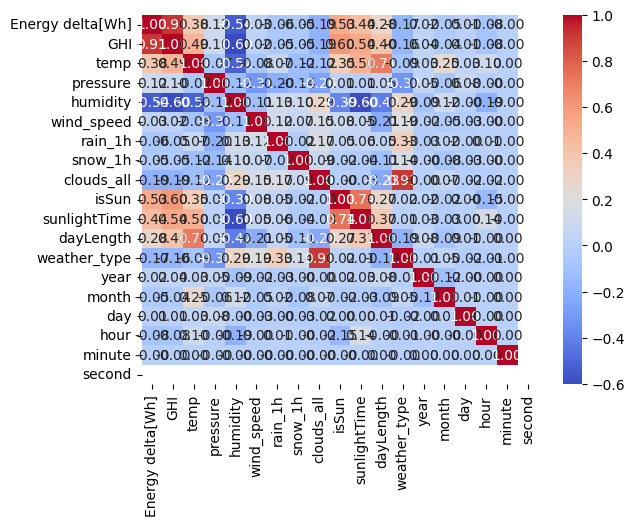

In [ ]:
# get correlations for all columns
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")

In [ ]:
# form the correlation variable created above let's get the top 3 (using absolute value to get either positive or negative) correlations with Energy delta
corr[['Energy delta[Wh]']].abs().sort_values(by='Energy delta[Wh]', axis=0, ascending=False)

,Energy delta[Wh]
Energy delta[Wh],1.000000
GHI,0.914619
humidity,0.544407
isSun,0.526952
sunlightTime,0.437296
temp,0.378554
dayLength,0.280695
clouds_all,0.190241
weather_type,0.170046
pressure,0.115219


In [ ]:
#df=df.drop(['day','minute','second','year','wind_speed','month','snow_1h','rain_1h','hour','pressure','weather_type','clouds_all','dayLength','temp','sunlightTime','isSun'],axis=1)

In [ ]:
df.describe()

,Energy delta[Wh],GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,isSun,sunlightTime,dayLength,weather_type,year,month,day,hour,minute,second
count,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.0
mean,573.008228,32.596538,9.790521,1015.292780,79.810566,3.937746,0.066035,0.007148,65.974387,0.519962,211.721094,748.644347,3.198398,2019.345042,6.298329,15.744481,11.498902,22.500000,0.0
std,1044.824047,52.172018,7.995428,9.585773,15.604459,1.821694,0.278913,0.069710,36.628593,0.499603,273.902186,194.870208,1.289939,1.636537,3.376066,8.812357,6.921887,16.770552,0.0
min,0.000000,0.000000,-16.600000,977.000000,22.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,450.000000,1.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.0
25%,0.000000,0.000000,3.600000,1010.000000,70.000000,2.600000,0.000000,0.000000,34.000000,0.000000,0.000000,570.000000,2.000000,2018.000000,3.000000,8.000000,5.000000,11.250000,0.0
50%,0.000000,1.600000,9.300000,1016.000000,84.000000,3.700000,0.000000,0.000000,82.000000,1.000000,30.000000,765.000000,4.000000,2019.000000,6.000000,16.000000,11.000000,22.500000,0.0
75%,577.000000,46.800000,15.700000,1021.000000,92.000000,5.000000,0.000000,0.000000,100.000000,1.000000,390.000000,930.000000,4.000000,2021.000000,9.000000,23.000000,17.000000,33.750000,0.0
max,5020.000000,229.200000,35.800000,1047.000000,100.000000,14.300000,8.090000,2.820000,100.000000,1.000000,1020.000000,1020.000000,5.000000,2022.000000,12.000000,31.000000,23.000000,45.000000,0.0


In [ ]:
df.shape

(196776, 19)

In [ ]:
X=df.drop('Energy delta[Wh]',axis=1)

y=df['Energy delta[Wh]']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
regr = XGBRegressor(objective='reg:squarederror', random_state=42)
regr.fit(X_train,y_train)
y_pred = regr.predict(X_test)
# store the original and predicted value in a dataframe
df_final = pd.DataFrame(data={'Predictions':y_pred, 'Actuals':y_test })

# the model gives some negative predictions which doesn't make sense so set them to 0
print(df_final[df_final['Predictions']<0].head())
# set these negative values to 0
#df_final['Predictions'][df_final['Predictions']<0] = 0

print(df_final[df_final['Predictions']>0].head(10))
print(df_final.head(15))

        Predictions  Actuals
191706    -0.770575        0
150704    -6.128719        0
172776    -7.846042        0
67686     -2.440451        0
194409    -2.402168        0
        Predictions  Actuals
110142   492.895142      392
188361     0.995743        0
75797   1273.239990      881
134025     0.737714        0
99145      9.132332        0
86867     20.191200        0
122240  2690.641357     1666
87912    113.642296      133
107667   765.607117     1115
181656   470.307312      343
        Predictions  Actuals
110142   492.895142      392
191706    -0.770575        0
150704    -6.128719        0
188361     0.995743        0
75797   1273.239990      881
172776    -7.846042        0
67686     -2.440451        0
134025     0.737714        0
99145      9.132332        0
86867     20.191200        0
122240  2690.641357     1666
87912    113.642296      133
194409    -2.402168        0
69779     -5.764439        0
107667   765.607117     1115


Empty DataFrame
Columns: [Predictions, Actuals]
Index: []

Accuragy of testing for XGBRegressor                                     = 0.94

Accuragy of training for XGBRegressor                                     = 0.95
The Coefficient of determination (R-squared) for XGBRegressor = 0.94
The mean absolute error (MAE) for XGBRegressor                = 112.96
The RMSE error (RMSE) for XGBRegressor                        = 69236.71


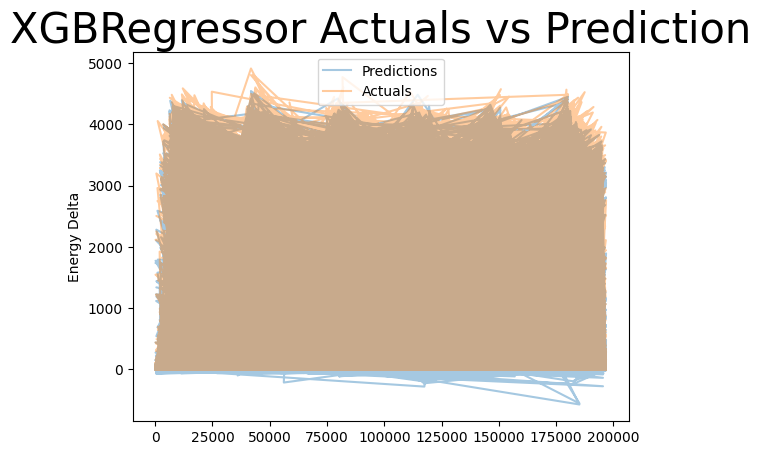

In [ ]:
#print them again just to confirm
print(df_final[df_final['Predictions']==0].head())
# zoom in to 300 values - note due to stratification the samples are random and the whole timeseries appears
df_final.plot(alpha=0.4) # reduce opacity to see both lines
plt.title('XGBRegressor Actuals vs Prediction', fontsize=30)
plt.ylabel('Energy Delta')
print('\nAccuragy of testing for XGBRegressor                                     = {:.2f}'.format(regr.score(X_test, y_test)))
print('\nAccuragy of training for XGBRegressor                                     = {:.2f}'.format(regr.score(X_train, y_train)))
print('The Coefficient of determination (R-squared) for XGBRegressor = {:.2f}'.format(r2_score(df_final['Actuals'],df_final['Predictions'])))
print('The mean absolute error (MAE) for XGBRegressor                = {:.2f}'.format(mean_absolute_error( df_final['Actuals'],df_final['Predictions'])))
print('The RMSE error (RMSE) for XGBRegressor                        = {:.2f}'.format(mean_squared_error( df_final['Actuals'],df_final['Predictions']), squared=True))